In [5]:
!pip uninstall -y jax jaxlib
!pip install --upgrade jax jaxlib tensorflow

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing install

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import hilbert

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define file path in Google Drive
drive_path = "/content/drive/My Drive/TimeSeries/historical_data.csv"

# Load dataset
df = pd.read_csv(drive_path, parse_dates=['Date'], index_col='Date')

# Ensure the data is sorted by date
df = df.sort_index()

# Select the 'Close' column
data = df[['Close']].copy()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0097 - val_loss: 0.0014
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 2.0192e-04 - val_loss: 0.0011
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 1.8691e-04 - val_loss: 0.0012
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.0651e-04 - val_loss: 0.0011
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.9224e-04 - val_loss: 8.8185e-04
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.7503e-04 - val_loss: 0.0012
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.9473e-04 - val_loss: 0.0017
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 2.1781e-04 - val_loss: 7.5713e-04
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 1.7201e-04 - val_loss: 6.5441e-04
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 1.5839e-04 - val_loss: 6.1805e-04
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.2093e-04 - val_loss: 5.

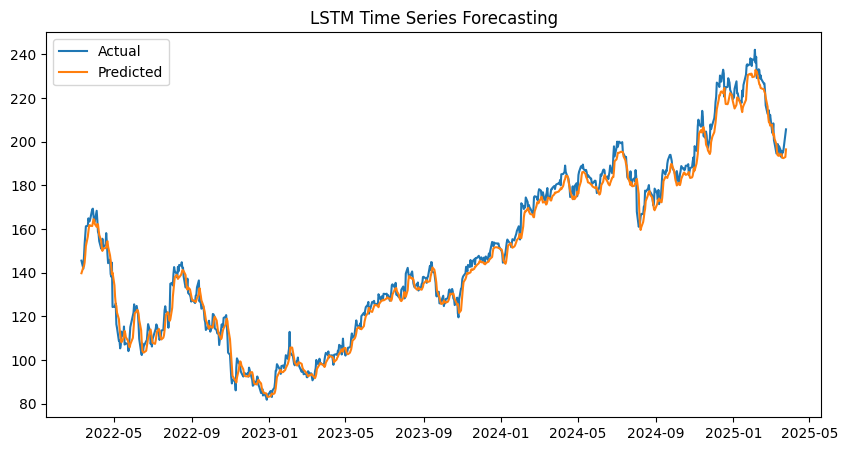

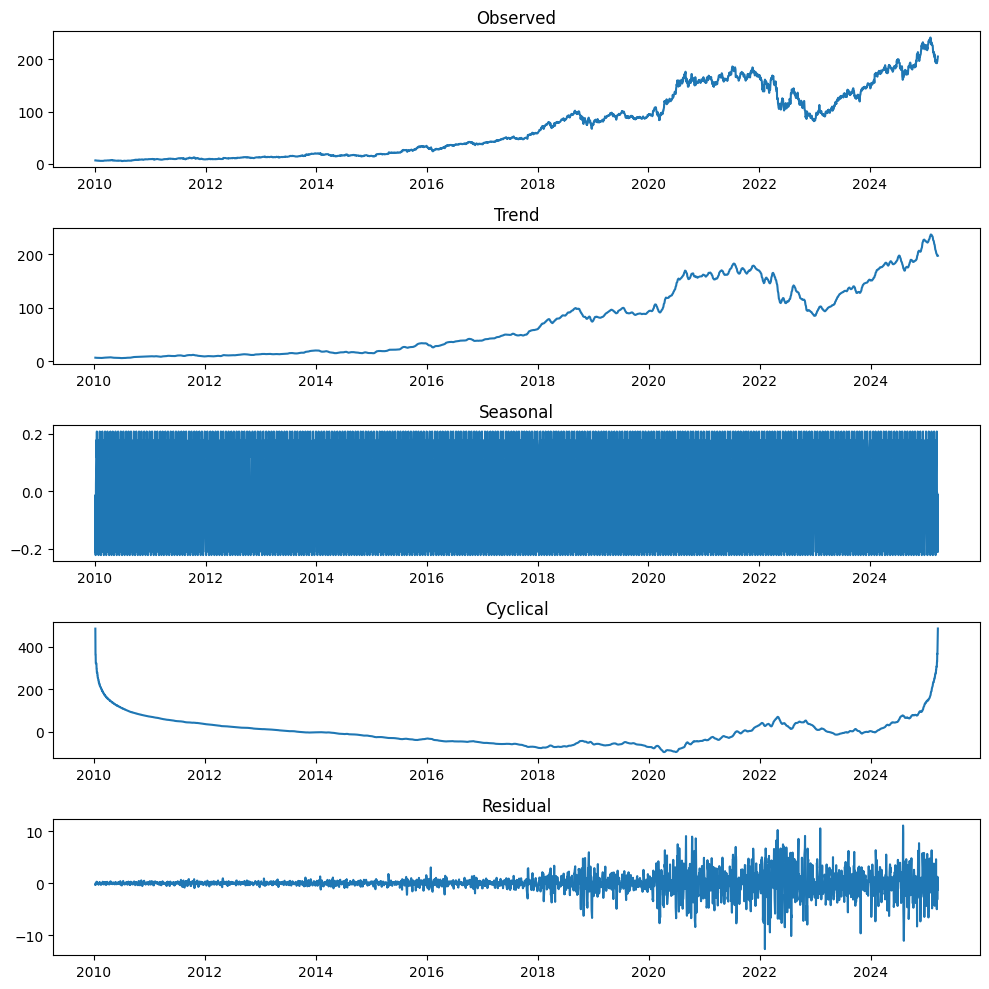

In [10]:
# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(data_scaled, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(data.index[-len(y_test):], predictions, label='Predicted')
plt.legend()
plt.title('LSTM Time Series Forecasting')
plt.show()

# Time Series Decomposition
decomposed = seasonal_decompose(data, model='additive', period=12)
fig, axes = plt.subplots(5, 1, figsize=(10, 10))

# Compute Cyclical Component using Hilbert Transform
cyclical = np.imag(hilbert(decomposed.trend.dropna().values))
cyclical_series = pd.Series(cyclical, index=decomposed.trend.dropna().index)

# Ensure components have the same length as the original data
aligned_components = [
    decomposed.observed,
    decomposed.trend,
    decomposed.seasonal,
    cyclical_series.reindex(decomposed.trend.index),  # Align cyclical component with the same index as trend
    decomposed.resid
]

# Plot Components
components = ['Observed', 'Trend', 'Seasonal', 'Cyclical', 'Residual']
for i, component in enumerate(aligned_components):
    axes[i].plot(decomposed.observed.index, component)  # Use the index from observed to ensure alignment
    axes[i].set_title(components[i])

plt.tight_layout()
plt.show()
